# Railroad Accident/Incident Analysis in US



#### Data Source:
Rail Equipment Accident/Incident Data from FRA in the US Department of Transportation <br/>
https://data.transportation.gov/Railroads/Rail-Equipment-Accident-Incident-Data/85tf-25kj

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gmaps
from api_keys import gmap_key
gmaps.configure(api_key=gmap_key)
from scipy.stats import linregress

## 1. Understanding Data Scope
e.g. Year recorded, what type of trains considered, what type of accident recorded<br/>

In [2]:
data = pd.read_csv("../../Test Data/Rail_Equipment_Accident_Incident_Data.csv")
print(f"There are {data.shape[0]} records availabe and {data.shape[1]} information recorded")
print("-------------------------------------------------------")

# available information is listed and explained in the above link
year_since = data["Report Year"].min()
year_to = data["Report Year"].max()
print(f"The datasets record year from {year_since} to {year_to}")
print("-------------------------------------------------------")
print(data["Equipment Type"].unique())
print("-------------------------------------------------------")
print(data["Track Type"].unique())

C:\Users\Eva\anaconda3\envs\bootcamp\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (26,42,45,46,49,58,60,61,62,63,64,65,66,67,68,70,129,130,135) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


There are 214157 records availabe and 159 information recorded
-------------------------------------------------------
The datasets record year from 1975.0 to 2022.0
-------------------------------------------------------
['Passenger Train - Pulling' 'Single Car' 'Freight Train' 'Yard/switching'
 'Light loco(s)' 'Cut of cars' nan 'Passenger Train - Pushing'
 'Maint./inspect Car' 'EMU' 'Work train' 'Spec. MoW Equip.'
 'Commuter Train - Pulling' 'Commuter Train - Pushing' 'DMU']
-------------------------------------------------------
['Main' 'Yard' 'Industry' nan 'Siding']


## 2. Train Accident Overview

This section investigates total numbers of accidents and fatalities trending performance over the recent 30 years by using line plots.

It shows that both total numbers of accidents and fatalities in US have been decreased in the recent 10 years.

In [3]:
# get relevant data into dataframe
overview_df = data.loc[(data["Report Year"] >= 1992.0) & (data["Report Year"]<=2021.0)]
group_year = overview_df.groupby("Report Year")
year_acc_no = group_year[["Accident Number"]].count().reset_index()
year_fatal_no = group_year[["Total Persons Killed"]].sum().reset_index()

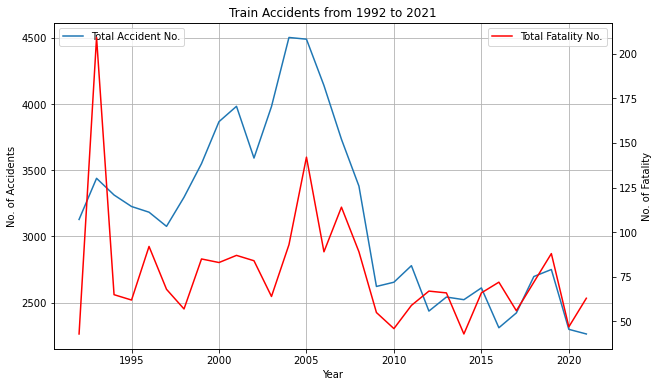

In [4]:
# draw the line plot
fig,ax = plt.subplots(figsize=(10,6))

year_acc_no.plot.line(x="Report Year",y="Accident Number",ax=ax,title="Train Accidents from 1992 to 2021")
year_fatal_no.plot.line(x="Report Year",y="Total Persons Killed",ax=ax,secondary_y=True,color="r")

ax.legend(["Total Accident No."],loc="upper left")
ax.right_ax.legend(["Total Fatality No."])
ax.set_xlabel("Year")
ax.set_ylabel("No. of Accidents")
ax.right_ax.set_ylabel("No. of Fatality")
ax.grid()

plt.savefig("Train Accidents from 1992 to 2021.png")

In [5]:
# to numerically see whether train become safer
acc_10 = year_acc_no.loc[(year_acc_no["Report Year"]>=2012)&(year_acc_no["Report Year"]<=2021)]["Accident Number"].mean()
acc_20 = year_acc_no.loc[(year_acc_no["Report Year"]>=2001)&(year_acc_no["Report Year"]<=2012)]["Accident Number"].mean()
acc_30 = year_acc_no.loc[(year_acc_no["Report Year"]>=1992)&(year_acc_no["Report Year"]<=2002)]["Accident Number"].mean()
print(acc_10,acc_20,acc_30)

fat_10 = year_fatal_no.loc[(year_acc_no["Report Year"]>=2012)&(year_fatal_no["Report Year"]<=2021)]["Total Persons Killed"].mean()
fat_20 = year_fatal_no.loc[(year_acc_no["Report Year"]>=2001)&(year_fatal_no["Report Year"]<=2012)]["Total Persons Killed"].mean()
fat_30 = year_fatal_no.loc[(year_acc_no["Report Year"]>=1992)&(year_fatal_no["Report Year"]<=2002)]["Total Persons Killed"].mean()
print(fat_10,fat_20,fat_30)

2485.1 3524.5 3423.0
64.0 82.41666666666667 85.0


In [6]:
year_fatal_no.to_csv("total killed.csv")

## 3. Train Accident by Cause

This section investigates what major causes resulting in the recent 10 years' train accidents in US by using bar plots.

Additional data source used: accident cause code<br/>
https://railroads.dot.gov/forms-guides-publications/guides/train-accident-cause-codes-file

Causes are categoried into human factors, track related, equipment, signal, and miscellaneous like environment related.<br/>
It shows that human factor is the major cause for the train accident in the last 10 years.

In [7]:
# load the accident cause code data
data_cause = pd.read_csv("../../Test Data/Appendix C_Train_Accident_Cause_Codes.csv")[["Code","Title"]]

# check whether all recorded code could be found from code list
cause_ls = len(data_cause["Code"].unique())
record_ls = len(data["Primary Accident Cause Code"].unique())
print(f"There are {cause_ls} kinds of causes in total")
print("-------------------------------------------------------")
print(f"There are {record_ls} kinds of causes recorded")

There are 390 kinds of causes in total
-------------------------------------------------------
There are 390 kinds of causes recorded


In [8]:
# The above figures imply that each record could find a cause from the reference dataset
# however, when further investigating, the format of reference dataset is different from the records
# needs further cleaning
data_cause = data_cause.dropna()

new_code=[]
for i in range(len(data_cause.Code)):
    new = data_cause["Code"][i][:4]
    new_code.append(new)

data_cause["Primary Accident Cause Code"] = new_code
data2 = data[["Report Year","Accident Number","Primary Accident Cause Code"]]
data_cause_ana = pd.merge(data2,data_cause,how="left",on="Primary Accident Cause Code")
data_cause_ana.head()

,Report Year,Accident Number,Primary Accident Cause Code,Code,Title
0,2011.0,20110041,M406,M406,Miscellaneous Causes Not Otherwise Listed
1,2010.0,000074975,S016,S016,Signal and Communication
2,1998.0,059812027,E21C,E21C,Mechanical and Electrical Failures
3,1987.0,WA17,H702,H702,Train operation - Human Factors
4,2007.0,543854,T311,T311,"Rack, Roadbed and Structures"


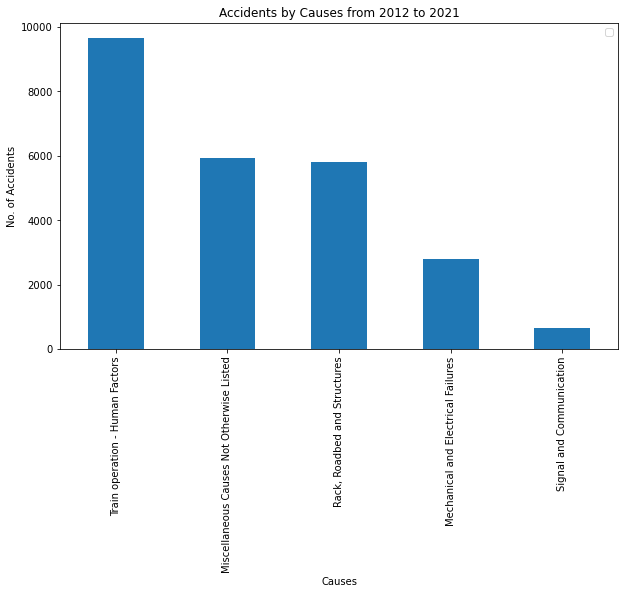

In [9]:
# bar plot
data_cause_plot = data_cause_ana.loc[(data_cause_ana["Report Year"]>=2012)&(data_cause_ana["Report Year"]<=2021)]
data_cause_plot1 = data_cause_plot.groupby("Title")[["Accident Number"]].count().sort_values(by="Accident Number",ascending=False)

data_cause_plot1.plot.bar(figsize=(10,6))
plt.xlabel("Causes")
plt.ylabel("No. of Accidents")
plt.title("Accidents by Causes from 2012 to 2021")
plt.legend("")
plt.show()

In [10]:
# what specific numbers for primary cause, and its %
data_cause_sum = data_cause_plot1.reset_index()
human = data_cause_sum.loc[data_cause_sum["Title"]=="Train operation - Human Factors"]["Accident Number"][0]
total = data_cause_sum["Accident Number"].sum()
human_per = human / total 
print(total, human_per)

24832 0.38865173969072164


## 4. Train Accident by Type

This section investigates what types of accidents happening in the recent 10 years in US by using bar plots. 

All accidents can be categorised into 5 different types, including derailment, crossing, collision, obstruction and other impacts.<br/>
It shows that most of accidents are derailments.

In [11]:
# explore types of accidents and categories into reasonable segments
data["Accident Type"].unique()

array(['Fire/violent rupture', 'Other impacts', 'Side collision',
       'Derailment', 'Broken train collision', 'Hwy-rail crossing',
       'Other (describe in narrative)', 'Rear end collision',
       'Obstruction', 'Head on collision', 'Explosion-detonation',
       'Raking collision', 'RR grade crossing', nan], dtype=object)

In [12]:
# There seems to be no standard for categorising types of accidents <br/>
# so investigated one year data as an example and some common sense to determine the type
de = ["Derailment"]
ob = ["Obstruction"]
cr = ["Hwy-rail crossing","RR grade crossing"]
co = ["Side collision","Broken train collision","Rear end collision","Head on collision","Raking collision"]
oth = ["Fire/violent rupture","Explosion-detonation","Other (describe in narrative)","Other impacts"]

data3 = data[["Report Year","Accident Number","Accident Type"]]

In [13]:
# add types into the dataframe
type_list = []

for i in range(len(data3["Accident Type"])):
    acc_type = data3["Accident Type"][i]
    
    if acc_type in de:
        type_list.append("Derailment")
    elif acc_type in ob:
        type_list.append("Obstruction")
    elif acc_type in cr:
        type_list.append("Crossing")
    elif acc_type in co:
        type_list.append("Collision")
    elif acc_type in oth:
        type_list.append("Other Impacts")
    else:
        type_list.append("Not Available")

data3["Type_cat"] = type_list

C:\Users\Eva\anaconda3\envs\bootcamp\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


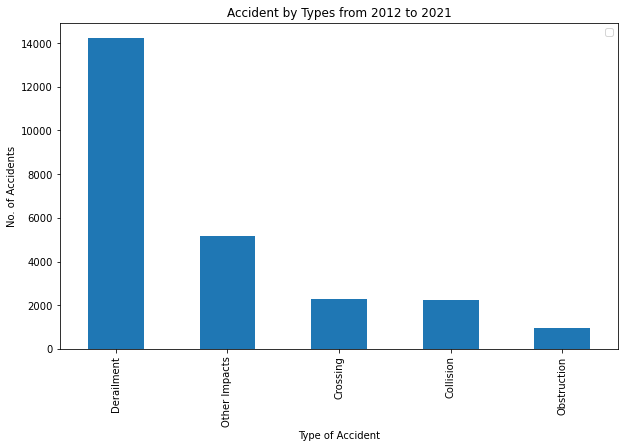

In [14]:
# bar plot
data_type_ana= data3.loc[(data3["Report Year"]>=2012)&(data3["Report Year"]<=2021)]
data_type_plot = data_type_ana.groupby("Type_cat")[["Accident Number"]].count().sort_values(by="Accident Number",ascending=False)

data_type_plot.plot.bar(xlabel="Type of Accident",title="Accident by Types from 2012 to 2021",figsize=(10,6))
plt.ylabel("No. of Accidents")
plt.legend("")
plt.show()

## 5. Train Accident by Locations

This section investigates:
1. locations of accidents in recent 10 years by using a heatmap
2. a group-wise topic：how fatality rates are by different vehicles in different states (for this one, my part is contributing data)

It shows that a lot of accidents in the recent 10 years happened in the eastern-side of US, including cities like Chicago, New York and Houston.

### 5.1 Locations of accidents

In [15]:
# explore data
data4 = data.loc[(data["Report Year"]>=2012)&(data["Report Year"]<=2021)]
location = data4[["Latitude","Longitude"]]

lat_range1 = location["Latitude"].min()
lat_range2 = location["Latitude"].max()
lon_range1 = location["Longitude"].min()
lon_range2 = location["Longitude"].max()
print(f"The most north point with latitude of {lat_range1}")
print(f"The most south point with latitude of {lat_range2}")
print(f"The most west point with longitude of {lon_range1}")
print(f"The most east point with longitude of {lon_range2}")

The most north point with latitude of 0.0
The most south point with latitude of 90.135623
The most west point with longitude of -683.19219
The most east point with longitude of 0.0


In [16]:
# it shows that there is wrong data input for Latitude & Longitude
location_modified = location.loc[(location["Latitude"]<=90) & (location["Longitude"]>= -180)]
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(location_modified,max_intensity=30,point_radius=0.3,dissipating=False)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

### 5.1 Fatality by state (group-wise topic)

In [17]:
data_fatality = data[["State Name","Report Year","Total Persons Killed"]]
data_fatality = data_fatality.loc[(data_fatality["Report Year"] >= 2010.0) & (data_fatality["Report Year"]<=2020.0) ]
state_fatality = data_fatality.groupby("State Name")["Total Persons Killed"].sum()
state_fatality.to_csv("fatality by state.csv")

## 6. Fatality Associated Factors

This section investigates whether speed is a related factor to fatality rates,

Speed is segmented into 4 ranges based on below info: <br/>
https://worldwiderails.com/how-fast-do-trains-go/<br/>
https://www.quora.com/What-is-the-average-speed-of-trains<br/>

It shows that even different speed ranges are tested, there is no correlation between speed and total people killed.

In [18]:
print(data["Train Speed"].min())
print(data["Train Speed"].max())
print(data["Train Speed"].count())

0.0
545.0
214154



There is one record with train speed over 500mph,<br/>
according to below article:<br/>
https://www.visualcapitalist.com/visualizing-the-fastest-trains-in-the-world/#:~:text=Japan's%20L0%20Series%20Maglev%20is,largest%20high%2Dspeed%20railway%20network.<br/>

It is very likely this record is wrong.

In [19]:
# clean and get data
data5 = data.loc[data["Train Speed"] < 400]
data_killed = data5[["Train Speed","Total Persons Killed"]]

# further segment speed to test
bins = [0,30,60,100,130]
label = ["0-30mph", "31-60mph","61-100mph","over 100mph"]
speed_range = pd.cut(data_killed["Train Speed"],bins=bins,labels=label,include_lowest=True)
data_killed["Speed Range"] = speed_range
data_killed.head()

C:\Users\Eva\anaconda3\envs\bootcamp\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Train Speed,Total Persons Killed,Speed Range
0,49.0,0.0,31-60mph
1,0.0,0.0,0-30mph
2,7.0,0.0,0-30mph
3,0.0,0.0,0-30mph
4,4.0,0.0,0-30mph


r value is 0.007491823031152553


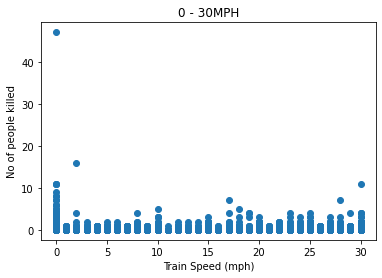

In [20]:
speed_low = data_killed.loc[data_killed["Speed Range"]=="0-30mph"]["Train Speed"]
killed_low = data_killed.loc[data_killed["Speed Range"]=="0-30mph"]["Total Persons Killed"]
plt.scatter(speed_low,killed_low)
print(f"r value is {linregress(speed_low,killed_low)[2]}")
plt.title("0 - 30MPH")
plt.xlabel("Train Speed (mph)")
plt.ylabel("No of people killed")
plt.show()

r value is 0.04760466663375595


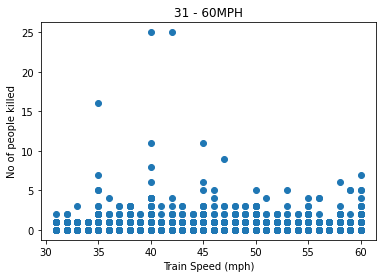

In [21]:
speed_2 = data_killed.loc[data_killed["Speed Range"]=="31-60mph"]["Train Speed"]
killed_2 = data_killed.loc[data_killed["Speed Range"]=="31-60mph"]["Total Persons Killed"]
plt.scatter(speed_2,killed_2)
print(f"r value is {linregress(speed_2,killed_2)[2]}")
plt.title("31 - 60MPH")
plt.xlabel("Train Speed (mph)")
plt.ylabel("No of people killed")
plt.show()

r value is 0.012529294448022761


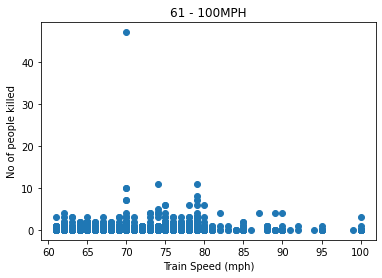

In [22]:
speed_3 = data_killed.loc[data_killed["Speed Range"]=="61-100mph"]["Train Speed"]
killed_3 = data_killed.loc[data_killed["Speed Range"]=="61-100mph"]["Total Persons Killed"]
plt.scatter(speed_3,killed_3)
print(f"r value is {linregress(speed_3,killed_3)[2]}")
plt.title("61 - 100MPH")
plt.xlabel("Train Speed (mph)")
plt.ylabel("No of people killed")
plt.show()

r value is -0.18477677089464764


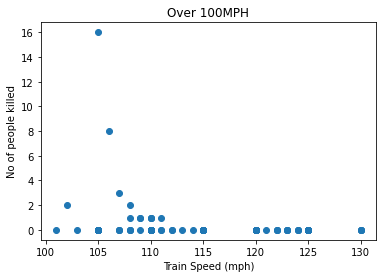

In [23]:
speed_4 = data_killed.loc[data_killed["Speed Range"]=="over 100mph"]["Train Speed"]
killed_4 = data_killed.loc[data_killed["Speed Range"]=="over 100mph"]["Total Persons Killed"]
plt.scatter(speed_4,killed_4)
print(f"r value is {linregress(speed_4,killed_4)[2]}")
plt.title("Over 100MPH")
plt.xlabel("Train Speed (mph)")
plt.ylabel("No of people killed")
plt.show()